# $B_s \rightarrow KK\mu\mu$ Documentation

This investigation has been detailed in 2 parts:
1. Background Reduction and Decay Reconstruction
2. Machine Learning and Branching Fraction (this notebook)


# Colab Notebook Setup

## Packages

While the Colab Notebook comes with `xgboost` installed, we have found it more suitable to upgrade it to the latest 1.X version instead of the preinstalled 0.9.0 due to increased stability in terms of model IO (i.e. saving to JSON).

In [1]:
#!pip install --upgrade xgboost

## Data

Data can be loaded from the saved output from the previous notebook (Part 1).

In [2]:
#%%
import matplotlib.pyplot as plt
"""
=============
plot settings
=============
"""

override = {
   'axes.labelsize':40,
   'font.size': 40,
   'legend.fontsize': 40,
   'legend.framealpha': 1,
   'legend.edgecolor': 'black',
   'grid.color': 'gainsboro',
   'grid.linewidth': 1.75,
   'xtick.labelsize': 40,
   'ytick.labelsize': 40,
   'figure.figsize': [13, 10],
   'lines.linewidth': 3,
   'font.family': 'DejaVu Sans',
   'mathtext.fontset': 'cm',
   'text.usetex': True
   } 

overridesmall = {
   'axes.labelsize':28,
   'font.size': 28,
   'legend.fontsize': 32,
   'legend.framealpha': 1,
   'legend.edgecolor': 'black',
   'grid.color': 'gainsboro',
   'xtick.labelsize': 28,
   'ytick.labelsize': 28,   
   'figure.figsize': [11, 8.5],
   'lines.linewidth': 3,
   'font.sans-serif': 'Computer Modern Sans serif',
   'mathtext.fontset': 'cm'
   } 

colors=["indianred","dodgerblue","darkorange","forestgreen","hotpink",
        "cornflowerblue","darkgoldenrod","sienna","yellowgreen","tomato"]


In [3]:
plt.rcdefaults()

rcParams = {
    'xtick.major.size': 1.5,
    'xtick.major.pad': 1.5,
    'axes.labelpad': 2,
    'axes.grid': True,
}
for k, v in rcParams.items():
    print(f"Set {k} to {v} from {plt.rcParams[k]}")
    plt.rcParams[k] = v

Set xtick.major.size to 1.5 from 3.5
Set xtick.major.pad to 1.5 from 3.5
Set axes.labelpad to 2 from 4.0
Set axes.grid to True from False


In [4]:
def event_counter(data_frame):
    actual_events=[]
    counter=0
    event_number=data_frame['eventNumber'].to_numpy()
    run_number=data_frame['eventNumber'].to_numpy()
    for i in range(len(event_number)):
        if (event_number[i] in actual_events)==False:
            actual_events.append(event_number[i])
            counter+=1
    return counter

Let's load the data and check it's what we want. First the actual data:

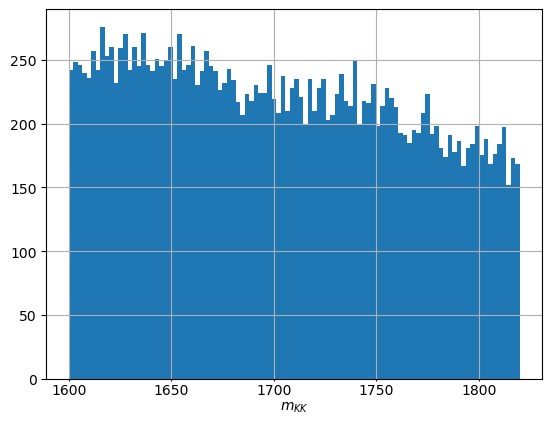

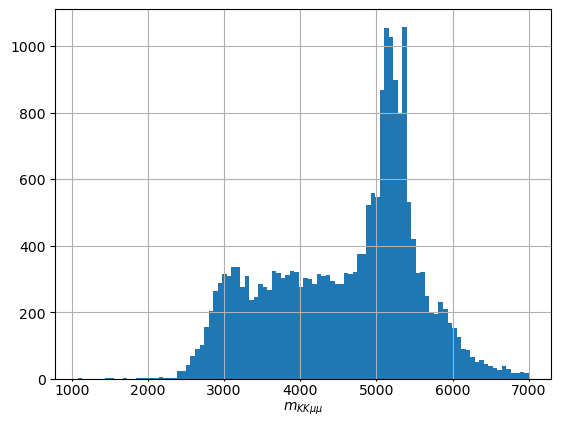

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

Bs_df = pd.read_pickle('Bs_reduced_tau_reconstructed_data_frame_SL.pkl.gz')

phi3mask=((Bs_df['phi3_M']>1600) & (Bs_df['phi3_M']<1820))

Bs_df=Bs_df.loc[phi3mask] # apply phi3 selection

plt.figure()
plt.hist(Bs_df['phi3_M'], bins=100)
plt.xlabel("$m_{KK}$")
plt.show()

plt.figure()
plt.hist(Bs_df['Bs_M'], bins=100)
plt.xlabel("$m_{KK \mu \mu}$")
plt.show()

Now the MC (both for signal and for control channel phimumu that we'll use as sanity check):

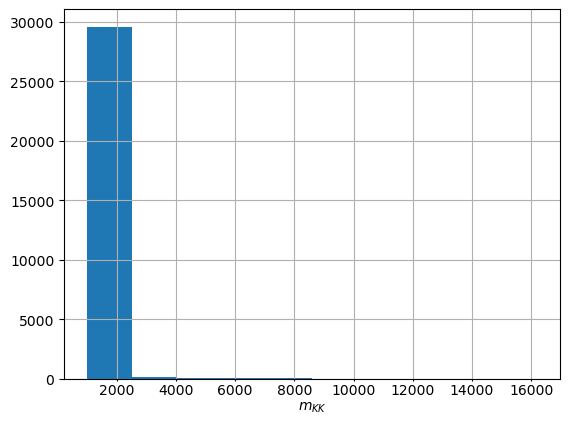

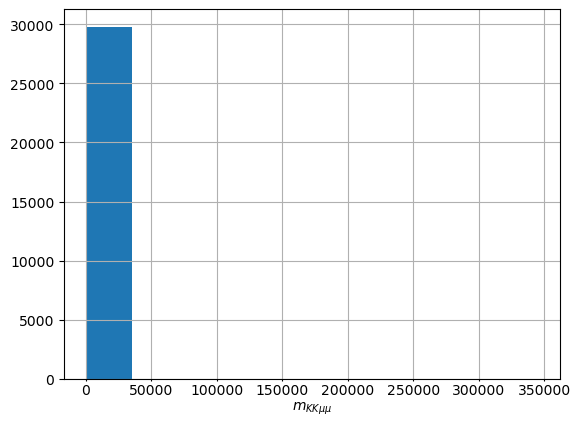

In [6]:
Bs_df_signal = pd.read_pickle('Bs_reduced_tau_reconstructed_data_frame_MC.pkl.gz')
# Bs_df_phimumu = pd.read_pickle('Bs_reduced_tau_reconstructed_data_frame_MC_phimumu.pkl.gz')

# truthmatch_phimumuMC= (
#     (Bs_df_phimumu['K_plus_TRUEID']==321) & (Bs_df_phimumu['K_minus_TRUEID']==-321) &
#     ((Bs_df_phimumu['mu_minus_MC_MOTHER_ID']==531)|(Bs_df_phimumu['mu_minus_MC_MOTHER_ID']==-531))
# )

truthmatch_signalMC= (
    (Bs_df_signal['Kplus_TRUE_ID']==321) & (Bs_df_signal['Kminus_TRUE_ID']==-321) & 
    (Bs_df_signal['phi3_TRUE_ID']==337)
)

# Bs_df_phimumu=Bs_df_phimumu.loc[truthmatch_phimumuMC]
Bs_df_signal=Bs_df_signal.loc[truthmatch_signalMC]

plt.figure()
plt.hist(Bs_df_signal['phi3_M'])
plt.xlabel("$m_{KK}$")
plt.show()

plt.figure()
plt.hist(Bs_df_signal['Bs_M'])
plt.xlabel("$m_{KK \mu \mu}$")
plt.show()

# plt.figure()
# plt.hist(Bs_df_phimumu['phi3_M'], bins=100)
# plt.xlabel("$m_{KK}$")
# plt.show()

# plt.figure()
# plt.hist(Bs_df_phimumu['Bs_M'], bins=100)
# plt.xlabel("$m_{KK \mu \mu}$")
# plt.show()

## Utilities

In [7]:
import numpy as np
import pandas as pd
from typing import List, Optional

masses = {'mu': 105.658, 'tau': 1777, 'proton': 938.272, 'K': 493.677, 'pi': 139.57, 'D0': 1865,
          'J/psi': 3097, 'psi(2S)': 3686, 'rho0': 770, 'rho1450': 1450, 'kstar': 892,
          'Lc': 2286, 'Lb': 5620, 'B': 5279}


def get_mass(data_frame: pd.DataFrame, particles_associations: List[List[str]]) -> pd.DataFrame:
    """
    Obtains the mass of different associations of particles
    :param data_frame:
    :param particles_associations: list of lists made of ['particle_P', 'particle']
    :return:
    """
    energy_series = [
        (data_frame.loc[:, particle_P] ** 2 + masses[particle] ** 2) ** 0.5
        for particle_P, particle in particles_associations
    ]
    energy = pd.concat(energy_series, axis=1).sum(axis=1)
    
    particle_Ps = [i[0] for i in particles_associations]
    
    momentums = {}
    for coord in ['X', 'Y', 'Z']:
        particle_P_coords = [f'{particle_P}{coord}' for particle_P in particle_Ps]
        momentum_series = data_frame.loc[:, particle_P_coords].sum(axis=1)
        momentums[coord] = momentum_series
    sum_momenta = (pd.concat(momentums.values(), axis=1) ** 2).sum(axis=1)
    mass = (energy ** 2 - sum_momenta) ** 0.5
    return mass


In [8]:
particles_associations = [['Kminus_P', 'K'], ['Kplus_P', 'K'], ['muminus_P', 'mu'], ['muplus_P', 'mu']]
Bs_df['_kkmumu_mass'] = get_mass(data_frame=Bs_df, particles_associations=particles_associations)



In [9]:
#BDT_COLUMNS = ['Bs_ENDVERTEX_CHI2', 'Bs_FDCHI2_OWNPV',
#    'mu_plus_IPCHI2_OWNPV', 'mu_minus_IPCHI2_OWNPV', 'K_plus_IPCHI2_OWNPV', 'K_minus_IPCHI2_OWNPV','_tau_minus_closest_dist',
#    '_tau_plus_closest_dist','_tau_minus_flight_dist','_tau_plus_flight_dist','_bs_angle_z','_taus_angle']


# BDT_COLUMNS = ['mu_plus_PT', 'mu_minus_PT', 'mu_plus_P', 'mu_minus_P','_tau_minus_closest_dist',
#    '_tau_plus_closest_dist','_tau_minus_flight_dist','_tau_plus_flight_dist','K_minus_PIDK','K_plus_PIDK',
#    'phi_ORIVX_CHI2','_tau_minus_phi_IP','_tau_plus_phi_IP',]

BDT_COLUMNS = ['muplus_PT', 'muminus_PT', 'muplus_P', 'muminus_P',
               'DOCA_mu_plus', 'DOCA_mu_minus', 'DOCA_chi2_mu_plus', 'DOCA_chi2_mu_minus',
               'FD_tau_plus', 'FD_tau_minus', 'FD_chi2_tau_plus', 'FD_chi2_tau_minus',
               'IP_mu_plus', 'IP_mu_minus', 'IP_chi2_mu_plus', 'IP_chi2_mu_minus',
               'Kminus_RichDLLk', 'Kplus_RichDLLk']




In [1]:
percentiles = [0.00135, 0.02275, 0.1, 0.25, 0.5]
sorted(list(set(percentiles + [1 - _p for _p in percentiles])))

[0.00135, 0.02275, 0.1, 0.25, 0.5, 0.75, 0.9, 0.97725, 0.99865]

# Signal region

## Finding the signal region

In [10]:
import numpy as np

percentiles = [0.00135, 0.02275, 0.1, 0.25, 0.5]

def find_cutoff_at_percentiles(array: np.ndarray):
    _percentiles = sorted(list(set(percentiles + [1 - _p for _p in percentiles])))

    cutoff_values = np.quantile(array, _percentiles)
    print("\n".join([f"{_percentile:.5f}\t{_cutoff:.0f}" for _percentile, _cutoff in zip(_percentiles, cutoff_values)]))
    return cutoff_values


Define the signal region for our data

0.00135	2514
0.02275	2625
0.10000	2817
0.25000	2982
0.50000	3227
0.75000	3507
0.90000	3662
0.97725	3729
0.99865	3749


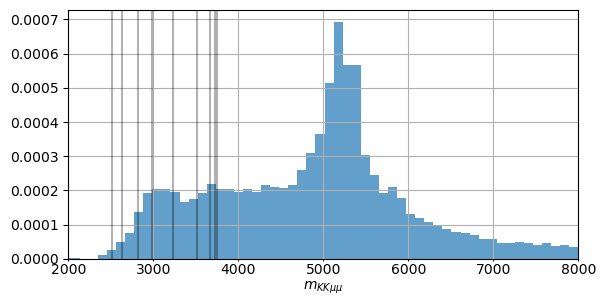

In [11]:
import matplotlib.pyplot as plt

_b_mass_distribution = Bs_df['_kkmumu_mass']

plt.figure(figsize=(6, 3))

for quantile in find_cutoff_at_percentiles(_b_mass_distribution.loc[(_b_mass_distribution > 2500) & (_b_mass_distribution < 3750)]):
    plt.axvline(quantile, color='k', alpha=0.3)

n, bins, patches = plt.hist(_b_mass_distribution, range=[0, 8e3], bins='auto', alpha=0.7, density=True)
plt.xlim((2e3, 8e3))
plt.xlabel(r'$m_{K K \mu \mu}$')
plt.tight_layout(pad=0.5)
plt.show()


In [12]:
#Bs_signal_region = [3103, 5624]
#Bs_signal_region = [5268, 5476]
Bs_signal_region = [2500,3750]

We have defined the signal region as the region inclusive of the $\pm 2 \sigma$ region of a normal distribution.

I.e. The mass limits that cover the 2.275th percentile to the 97.725th percentile.

In [13]:
_kkmumu_mass = 5366

def get_bs_kkmumu_mass_cut_mask(data_frame):
    """
    Returns a boolean mask that removes the lb -> pkmumu peak.
    I.e. False when event would fall inside the pkmumu peak.
    """
    _kkmumu_mass_width = 150

    mass_cut_mask = (data_frame._kkmumu_mass > _kkmumu_mass + _kkmumu_mass_width) | (data_frame._kkmumu_mass < _kkmumu_mass - _kkmumu_mass_width)
    print(f"kKmumu mass cut:\n{mass_cut_mask.value_counts()}")
    return mass_cut_mask


Define the background region

In [14]:
def get_and_plot_background_data(data_frame):
    bs_kkmumu_mass_cut_mask = get_bs_kkmumu_mass_cut_mask(data_frame)

    no_kkmumu_data_frame = data_frame.loc[bs_kkmumu_mass_cut_mask]

    background_df = Bs_df.loc[
         ((Bs_df['jpsi_M'] > 3020) & (Bs_df['jpsi_M'] < 3155) & (Bs_df['Bs_M'] > 5200) & (Bs_df['jpsi_M'] < 5500)) | 
        ((Bs_df['Bs_M']>5600) & ((Bs_df['jpsi_M'] < 3020) | (Bs_df['jpsi_M'] > 3155)) & ((Bs_df['jpsi_M'] < 3536) | (Bs_df['jpsi_M'] > 3873)))
    ]

    
    background_counts_left = (background_df._kkmumu_mass < Bs_signal_region[0]).sum()
    background_counts_right = (background_df._kkmumu_mass > Bs_signal_region[1]).sum()
    background_counts_str = f"Left: {background_counts_left}, Right: {background_counts_right}"

    signal_counts = len(no_kkmumu_data_frame) - background_counts_left - background_counts_right
    print(f"Counts:\n\tSignal: {signal_counts}\n\tBackground: {background_counts_str}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex='all', sharey='all')
    plot_range = (2000, 7000)
    ax1.hist(no_kkmumu_data_frame._kkmumu_mass, bins=100, range=plot_range, label='$B_s$ data')
    ax1.axvspan(*Bs_signal_region, color='red', alpha=0.3, label=f'Signal region: {signal_counts}\n($\pm 2\sigma$: 2.275 to 97.725 percentiles)')

    ax2.hist(background_df._kkmumu_mass, bins=100, range=plot_range, label=f'Background Proxy: {background_counts_str}')
    ax1.grid()
    ax2.grid()
    ax1.legend()
    ax2.legend()
    ax2.set_xlim(plot_range)
    ax2.set_xlabel(r'$m_{KK \mu\mu}$')
    plt.tight_layout(pad=0.5)
    return background_df


kKmumu mass cut:
True     19051
False     3067
Name: _kkmumu_mass, dtype: int64
Counts:
	Signal: 13797
	Background: Left: 0, Right: 5254


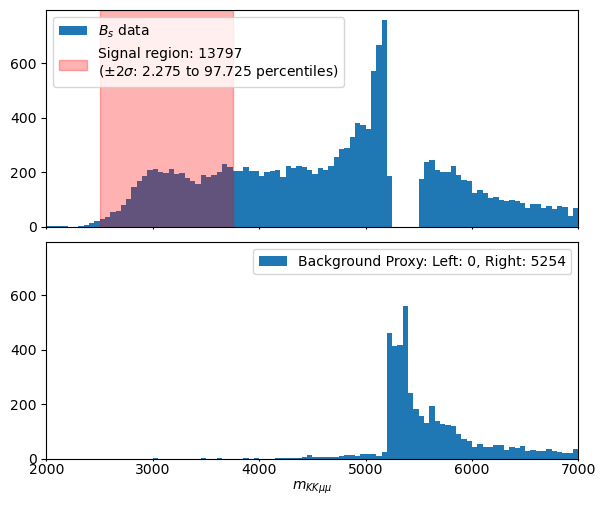

In [15]:
Bs_background_df = get_and_plot_background_data(Bs_df)

## Expected background in signal region

In [16]:
def find_expected_background_in_signal(background_data_frame):
    """
    Calculates the expected background in the signal region.
    
    Calculates the average density of candidates in the L left bins and R right bins.
    Extrapolates the average density across the width of the signal region.

    Here, L = 0, R = 627.
    """
    bg_mass = background_data_frame._kkmumu_mass

    bin_width = 50
    left_bins = 0
    right_bins = 627

    count_left = ((bg_mass > Bs_signal_region[0] - left_bins * bin_width) & (bg_mass < Bs_signal_region[0])).sum()
    count_right = ((bg_mass < Bs_signal_region[1] + right_bins * bin_width) & (bg_mass > Bs_signal_region[1])).sum()

    print(f"Left: {count_left} / {bin_width * left_bins} MeV")
    print(f"Right: {count_right} / {bin_width * right_bins} MeV")
    average_density = (count_left + count_right) / ((left_bins + right_bins) * bin_width)
    print(f"Average density: {average_density:.3f} / MeV")

    signal_region_width = Bs_signal_region[1] - Bs_signal_region[0]
    expected_background_in_signal = average_density * signal_region_width
    print(f"Expected background in signal region: {expected_background_in_signal:.2f}")
    return expected_background_in_signal


In [17]:
expected_background_in_signal = find_expected_background_in_signal(Bs_background_df)

Left: 0 / 0 MeV
Right: 5253 / 31350 MeV
Average density: 0.168 / MeV
Expected background in signal region: 209.45


# Machine Learning Classification

Prepare data for Boosted Decision Tree (BDT) training

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def get_x_and_y():

    cut_signal = Bs_df_signal
    signal = cut_signal.loc[:, BDT_COLUMNS]
    background = Bs_background_df.loc[:, BDT_COLUMNS]

    x = pd.concat([signal, background], axis=0, ignore_index=True)
    y1, y2 = np.ones(len(signal)), np.zeros(len(background))
    y = np.concatenate([y1, y2], axis=None)
    return x, y


In [31]:
X, y = get_x_and_y()
print(f"X: {X.to_numpy().shape}")
print(f"y: {y.shape}. ({np.unique(y, return_counts=True)})")

X: (35069, 18)
y: (35069,). ((array([0., 1.]), array([ 5257, 29812])))


In [1]:
X

NameError: name 'X' is not defined

## Punzi Figure of Merit

The figure of merit used to choose the threshold at which to cut on.

To maximise the sensitivity of the investigation, the figure of merit 

$\frac{\mathrm{TPR}}{\frac{a}{2} + \sqrt{\mathrm{FPR} \times B}}$

has to be maximised.

Here, $\mathrm{FPR} \times B$ represents the expected background remaining in the signal region after the cut.

In [32]:
a = 0.5
B = expected_background_in_signal

def calculate_punzi_fom(y_test: np.ndarray, y_pred: np.ndarray, thresholds: np.ndarray):
    y_test_bool = y_test.astype(bool)

    P = y_test.sum()
    N = len(y_test) - P

    foms_data = defaultdict(list)
    for threshold in thresholds:
        y_pred_class = y_pred > threshold
        TP = y_pred_class[y_test_bool].sum()
        TPR = TP / P
        FP = y_pred_class[~y_test_bool].sum()
        FPR = FP / N
        fom = TPR / (a / 2 + (FPR * B) ** 0.5)
        for variable in ['P', 'N', 'TP', 'FP', 'TPR', 'FPR', 'fom']:
            foms_data[variable].append(eval(variable))
    return foms_data


## Classifier performance evaluation

Here, we evaluate the performance of different model types.

These evaluations result in a TPR and FPR and FoM that is our best estimate for the individual models trained later.

(It is highly likely that the individual models trained later report slightly misleading TPRs and FPRs and FoMs due to the small number of test data).

We use 2-fold CV (where the data is split into equal parts test and train) in an attempt to maximise the amount of test data so the classifier statistics can be better approximated.

Better results may be achieved using higher-fold CV (e.g. 4-fold CV, where the data would be split into 3/4 train and 1/4 test), but the calculated model performance statistics would then be even more unreliable.



### Function definitions

Trains and evaluates many models using a specific strategy (e.g. 2-Fold CV).

In the plots generated, each grey line represents the performance of a single model that has been trained on one randomly-sampled half of the data and tested on the remaining half.

The figure of merit (FoM) is aggregated in two forms:
1. Calculated for each model, and the mean of all the individual FoMs is taken (orange)
2. The mean TPR and mean FPR across all models is taken, and a single FoM is calculated from this (green)

We use the threshold that maximises the second, as we also use the mean TPR and 
mean FPR in our efficiency/expected background calculations.

The first method is also extremely sensitive to the low amount of data, which pushes many FPRs to 0 prematurely.

In [33]:
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import defaultdict
import tqdm as tqdm
import scipy as sp


def get_foms(classifier, n_repeats: int = 100, n_splits: int = 2, weight_classes: bool = True):
    X, y = get_x_and_y()

    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

    thresholds = np.concatenate([np.linspace(0, 1, 200), np.linspace(0.95, 1, 100)])
    thresholds.sort()

    foms_datas = []

    for i, (train, test) in enumerate(tqdm.tqdm(cv.split(X, y), total=n_splits * n_repeats, desc='Split')):
        x_train = X.loc[train]
        y_train = y[train]
        y_train_bool = y_train.astype(bool)
        if weight_classes:
            sample_weight = get_sample_weight(y_train_bool)
            # print(f"{y_train_bool.sum()}, {(~y_train_bool).sum()}")
            classifier.fit(x_train, y_train, sample_weight=sample_weight)
        else:
            classifier.fit(x_train, y_train)
        if i==0:
            x_train_1=x_train
        else:
            x_train_2=x_train

        x_test = X.loc[test]
        y_test = y[test]
        # y_test_bool = y_test.astype(bool)

        y_pred_probabilities = classifier.predict_proba(x_test)
        y_pred = y_pred_probabilities[:, 1]

        # print(f"Length: Train: {len(y_train)}, {y_train.sum()}; Test: {len(y_test)}, {y_test.sum()}. i: {i}")
        # print(f"Length: Train: {len(y_train)}, {y_train_bool.sum()} True; "
        #       f"Test: {len(y_test)}, {y_test_bool.sum()} True. i: {i}")

        foms_data = calculate_punzi_fom(y_test, y_pred, thresholds)
        foms_datas.append(foms_data)

    # print(foms_array.shape)
    # np.savez(npz_file, foms=foms_array, thresholds=thresholds)
    return foms_datas, thresholds,x_train_1,x_train_2


def plot_foms(foms_datas, thresholds):
    fig, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex='all', figsize=(6, 7.5))
    runs = len(foms_datas)
    for i in range(runs):
        foms_data = foms_datas[i]
        foms = foms_data['fom']
        ax1.plot(thresholds, foms, lw=0.5, color='grey', alpha=0.1)
    
        ax2.plot(thresholds, foms_data['TPR'], '-', color='grey', alpha=0.1)
        ax2.plot(thresholds, foms_data['FPR'], '--', color='grey', alpha=0.1)
        
        ax3.plot(foms_data['FPR'], foms_data['TPR'], color='grey', alpha=0.1)
        

    foms_array = np.array([data['fom'] for data in foms_datas])
    foms_medians = np.median(foms_array, axis=0)
    # ax1.plot(thresholds, foms_medians, 'C0', lw=3, alpha=0.5, label='Median')
    ax1.plot(thresholds, np.mean(foms_array, axis=0), 'C1', lw=3, alpha=0.5, label='Mean')

    tprs_array = np.array([data['TPR'] for data in foms_datas])
    tpr_medians = np.median(tprs_array, axis=0)
    tprs_means = np.mean(tprs_array, axis=0)
    # ax2.plot(thresholds, tpr_medians, 'C0', lw=3, alpha=0.5, label='TPR Median')
    ax2.plot(thresholds, tprs_means, 'C1', lw=3, alpha=0.5, label='TPR Mean')

    fprs_array = np.array([data['FPR'] for data in foms_datas])
    fprs_medians = np.median(fprs_array, axis=0)
    fprs_means = np.mean(fprs_array, axis=0)
    # ax2.plot(thresholds, fprs_medians, 'C0--', lw=3, alpha=0.5, label='FPR Median')
    ax2.plot(thresholds, fprs_means, 'C1--', lw=3, alpha=0.5, label='FPR Mean')
    ax3.plot(fprs_means,tprs_means,'C1--', lw=3, alpha=0.5, label='ROC',color="indianred")
    
    AUROC=sp.integrate.trapz(tprs_means,fprs_means)
    
    print("AUROC: ",abs(AUROC))

    foms_from_means = tprs_means / (a / 2 + (fprs_means * B) ** 0.5)
    ax1.plot(
        thresholds,
        foms_from_means,
        'C2', lw=3, alpha=0.5,
        label='FoM from stat means'
    )

    foms_argmax = foms_from_means.argmax()
    threshold_max = thresholds[foms_argmax]
    ax1.axvline(
        threshold_max, 
        label=f'FoM max: {foms_from_means.max():.3f} at {threshold_max:.3f}', 
        color='k', 
        lw=1, 
        alpha=0.5
    )
    ax2.axvline(
        threshold_max, 
        color='k', 
        lw=1, 
        alpha=0.5
    )
    print(f'Medians: \tTPR: {tpr_medians[foms_argmax]:.3f}. FPR: {fprs_medians[foms_argmax]:.3f} (at {threshold_max:.3f})')
    print(f'Means:   \tTPR: {tprs_means[foms_argmax]:.3f}. FPR: {fprs_means[foms_argmax]:.3f} (at {threshold_max:.3f})')

    print(f'FoMs from means: {foms_from_means[foms_argmax]:.3f}  (at {threshold_max:.3f})')

    ax1.grid()
    ax2.grid()
    ax3.grid()

    ax2.set_xlabel("Classifier Threshold")
    
    ax1.set_ylabel("Figure of Merit")
    ax2.set_ylabel("Rates")
    
    ax3.set_xlabel("FPR")
    ax3.set_ylabel("TPR")
    
    
    ax1.legend(loc=2)
    ax2.legend(loc=10)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 5)
    ax2.set_ylim(0, 1)
    plt.tight_layout(pad=0.5)
    plt.show()
    
    plt.figure()
    plt.plot(fprs_means,tprs_means,'C1--', lw=3, alpha=0.5, label='ROC',color="indianred")
    
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.ylim(0.75,1)
    plt.xlim(0,0.1)
    plt.show()

    mean_tpr = tprs_means[foms_argmax]
    mean_fpr = fprs_means[foms_argmax]
    return threshold_max, mean_tpr, mean_fpr


In [34]:
def get_sample_weight(y_bool):
    sample_weight = np.zeros_like(y_bool, dtype=np.float32)
    normalisation = len(y_bool)

    sample_weight[y_bool] =  normalisation / y_bool.sum()
    sample_weight[~y_bool] =  normalisation / (~y_bool).sum()
    return sample_weight


### XGBoost

In [35]:
import xgboost

#### XGBoost with Dart Booster

In [36]:
# Ensures the classes are weighted equally despite imbalanced samples.
scale_pos_weight = (y==0).sum() / (y==1).sum() * 0.5
scale_pos_weight

0.08816919361331008

Split: 100%|██████████| 200/200 [09:14<00:00,  2.77s/it]


AUROC:  0.9950882303993899
Medians: 	TPR: 0.455. FPR: 0.000 (at 0.999)
Means:   	TPR: 0.454. FPR: 0.000 (at 0.999)
FoMs from means: 1.203  (at 0.999)


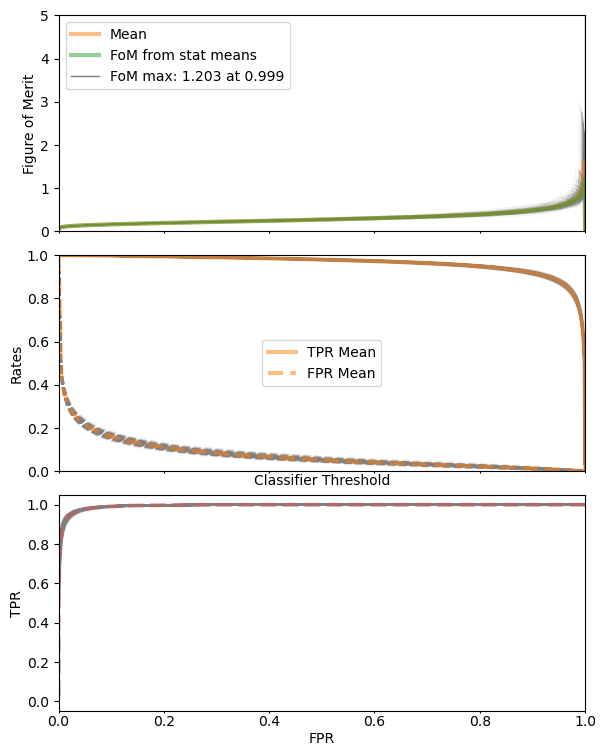

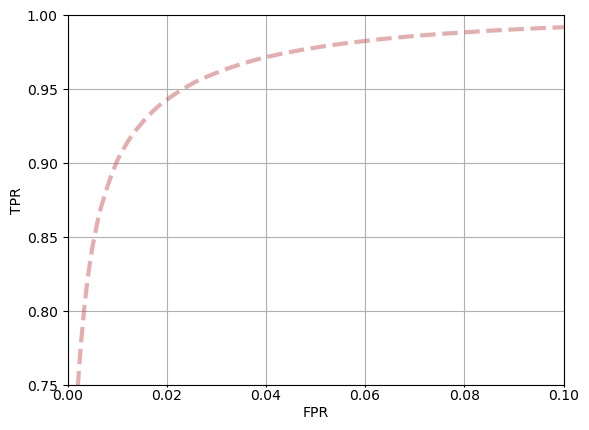

In [37]:
def train_dart_booster():
    xgb = xgboost.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        booster='dart'
    )
    foms_datas, thresholds,x_train_1,x_train_2 = get_foms(xgb, n_repeats=100, weight_classes=False)
    threshold, tpr, fpr=plot_foms(foms_datas, thresholds)
    return threshold, tpr, fpr,x_train_1,x_train_2

threshold, tpr, fpr,x_train_1,x_train_2=train_dart_booster()

## Classifier training and saving
Training and evaluation of actual models to be used

In [38]:
from sklearn.model_selection import StratifiedKFold
import pickle

def train_model(classifier, plot=False, save=False, is_xgb: bool = False, info_at_threshold=None, n_splits=2):
    X, y = get_x_and_y()

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    thresholds = np.linspace(0, 1, 500)
    if info_at_threshold :
        if info_at_threshold not in thresholds:
            thresholds = np.sort(np.concatenate([thresholds, [info_at_threshold]]))
        info_at_threshold_index = (thresholds == info_at_threshold).argmax()

  
    foms_datas = []
    y_test_bools = []
    y_test_preds = []
    for i, (train, test) in enumerate(cv.split(X, y)):
        x_train = X.loc[train]
        y_train = y[train]
        y_train_bool = y_train.astype(bool)

        if is_xgb:
            classifier.fit(x_train, y_train)
        else:
            sample_weight = get_sample_weight(y_train_bool)
            classifier.fit(x_train, y_train, sample_weight=sample_weight)

        x_test = X.loc[test]
        y_test = y[test]
        y_test_bool = y_test.astype(bool)

        # print(f"Length: Train: {len(y_train)}, {y_train.sum()}; Test: {len(y_test)}, {y_test.sum()}. i: {i}")
        prob = classifier.predict_proba(x_test)
        y_pred = prob[:, 1]
        foms_data = calculate_punzi_fom(y_test, y_pred, thresholds)
        foms_datas.append(foms_data)
        if info_at_threshold:
            print(f"Info at threshold: {info_at_threshold:.3f}:")
            for k, v in foms_data.items():
                print(f"\t{k}: {v[info_at_threshold_index]:.3f}")

        y_test_bools.append(y_test_bool)
        y_test_preds.append(y_pred)

        if save:
            file_name = f"classifier_MC{i}"
            if is_xgb:
                classifier.save_model(f"{file_name}.json")
            else:
                with open(f"{file_name}.pkl", "wb") as f:
                    pickle.dump(classifier, f)

    if plot:
        plot_model_performance(foms_datas, thresholds, y_test_bools, y_test_preds, classifier,Bs_df)

def plot_model_performance(foms_datas, thresholds, y_test_bools, y_test_preds, classifier,data_frame):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex='all', figsize=(6, 5))
    runs = len(foms_datas)
    
    model_x = data_frame.loc[:, BDT_COLUMNS].loc[(data_frame["Bs_M"]>2500) & (data_frame["Bs_M"]<3750)]
    model_x_2 = data_frame.loc[:, BDT_COLUMNS].loc[(data_frame["Bs_M"]>5500)]
    model_x_1 = data_frame.loc[:, BDT_COLUMNS].loc[(data_frame['jpsi_M'] > 3020) & (data_frame['jpsi_M'] < 3155)]
    # model_x_3= Bs_df_phimumu.loc[:, BDT_COLUMNS]
    
    model_y_pred =  classifier.predict_proba(model_x)[:, 1]
    model_y_pred_1 =  classifier.predict_proba(model_x_1)[:, 1]
    model_y_pred_2 =  classifier.predict_proba(model_x_2)[:, 1]
    # model_y_pred_3 =  classifier.predict_proba(model_x_3)[:, 1]
    
    for i in range(runs):
        classifier_i = i + 1
        foms_data = foms_datas[i]
        foms = foms_data['fom']
        ax1.plot(thresholds, foms, lw=1, color=f'C{i}', alpha=0.5, label=f"Classifier {classifier_i}")
    
        ax2.plot(thresholds, foms_data['TPR'], '-', color=f'C{i}', alpha=0.7, label=f'TPR {classifier_i}')
        ax2.plot(thresholds, foms_data['FPR'], '--', color=f'C{i}', alpha=0.7, label=f'FPR {classifier_i}')

    tprs_array = np.array([data['TPR'] for data in foms_datas])
    tprs_means = np.mean(tprs_array, axis=0)
    ax2.plot(thresholds, tprs_means, 'C1', lw=3, alpha=0.5, label='TPR Mean')

    fprs_array = np.array([data['FPR'] for data in foms_datas])
    fprs_means = np.mean(fprs_array, axis=0)
    ax2.plot(thresholds, fprs_means, 'C1--', lw=3, alpha=0.5, label='FPR Mean')

    foms_from_means = tprs_means / (a / 2 + (fprs_means * B) ** 0.5)
    ax1.plot(
        thresholds,
        foms_from_means,
        'r', lw=3, alpha=0.5,
        label='FoM from stat means'
    )

    ax1.grid()
    ax2.grid()
    ax2.set_xlabel("Classifier Threshold")
    ax1.set_ylabel("Figure of Merit")
    ax2.set_ylabel("Rates")
    ax1.legend()
    ax2.legend()
    plt.tight_layout()

    fig, axs = plt.subplots(runs, 1, figsize=(6, 5), sharex='all')
    for i in range(runs):
        ax = axs[i]
        y_test_bool = y_test_bools[i]
        y_test_pred = y_test_preds[i]
        plot_range = [0, 1]
        ax.hist(model_y_pred, bins=20, range=plot_range, label='Data', alpha=1,color="green")
        ax.hist(y_test_pred[~y_test_bool], bins=20, range=plot_range, label='Not event', alpha=0.8,color="lightcoral")
        ax.hist(y_test_pred[y_test_bool], bins=20, range=plot_range, label='Event', alpha=0.5,color="dodgerblue")
        ax.legend(loc=9)
        ax.grid()
        ax.set_yscale('log')
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()
    
    
    # plot BDT score
    fig = plt.figure()
    y_test_bool = y_test_bools[1]
    y_test_pred = y_test_preds[1]    
    plot_range = [0, 1]    
    # plt.hist(model_y_pred_3, bins=20, range=plot_range, label=r'$\phi \mu \mu$ MC', alpha=1,color="green")
    plt.hist(y_test_pred[~y_test_bool], bins=20, range=plot_range, label='Background Sample', alpha=0.7,color="orange")
    plt.hist(y_test_pred[y_test_bool], bins=20, range=plot_range, label='Signal MC', alpha=0.5,color="dodgerblue")
    plt.legend(loc=9)
    plt.grid()
    plt.yscale('log')
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()
    
    
    # plot BDT score for signal and backgorund proxies
    fig = plt.figure()
    y_test_bool = y_test_bools[1]
    y_test_pred = y_test_preds[1]    
    plot_range = [0, 1]
    plt.hist(model_y_pred_1, bins=20, range=plot_range, label=r'$J/\psi \ \phi_3$ Sample', alpha=1,color="orange")
    plt.hist(model_y_pred, bins=20, range=plot_range, label=r'Comb. Proxy ($m_{KK \mu \mu}>5.6$ GeV)', alpha=0.5, color="dodgerblue")
    plt.hist(model_y_pred, bins=40, range=plot_range, label=r'Signal Region ($m_{KK \mu \mu}<3.6$ GeV)',color="dodgerblue")
    plt.legend(loc=9)
    plt.grid()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Score')
    plt.tight_layout()
    plt.axvspan(0.8, 1, color='black', alpha=1)
    plt.ylim(bottom=0.8)
    plt.show()

    plt.figure()
    feature_importance = classifier.feature_importances_
    sorted_indices = np.argsort(feature_importance)
    pos = np.arange(sorted_indices.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_indices])
    plt.yticks(pos, X.columns[sorted_indices])
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

    
    # plotting BDT distributions for training vs testing to check against overfitting
    model_y_11 =  classifier.predict_proba(x_train_1)[:, 1]
    model_y_12 =  classifier.predict_proba(x_train_2)[:, 1]

    plt.figure()
    plot_range = [0, 1]
    plt.hist(model_y_11, bins=20, range=plot_range, label='Training Set', alpha=1,color="orange")
    plt.hist(model_y_12, bins=20, range=plot_range, label='Testing Set', alpha=0.5,color="dodgerblue")
    plt.legend(loc=9)
    plt.yscale('log')
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()

Info at threshold: 0.744:
	P: 14906.000
	N: 2629.000
	TP: 14242.000
	FP: 68.000
	TPR: 0.955
	FPR: 0.026
	fom: 0.371
Info at threshold: 0.744:
	P: 14906.000
	N: 2628.000
	TP: 14283.000
	FP: 65.000
	TPR: 0.958
	FPR: 0.025
	fom: 0.379


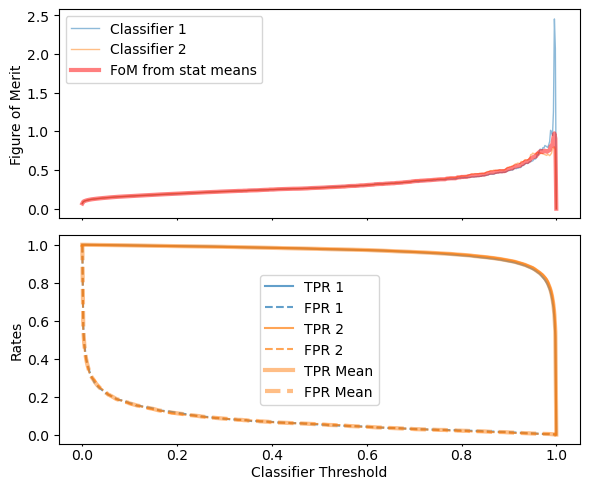

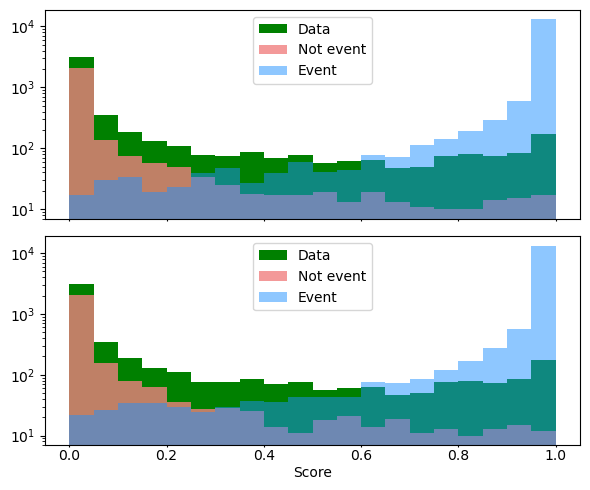

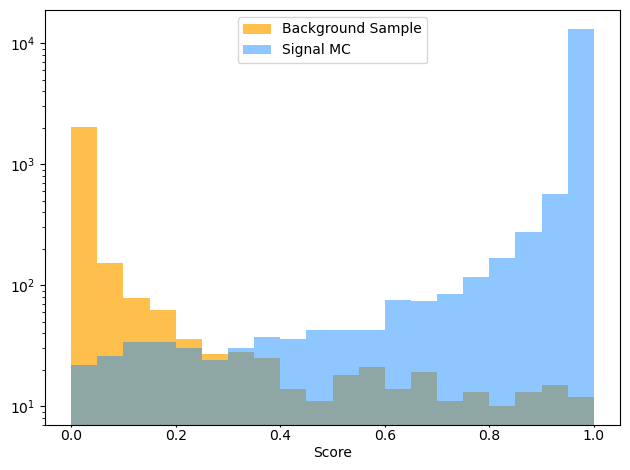

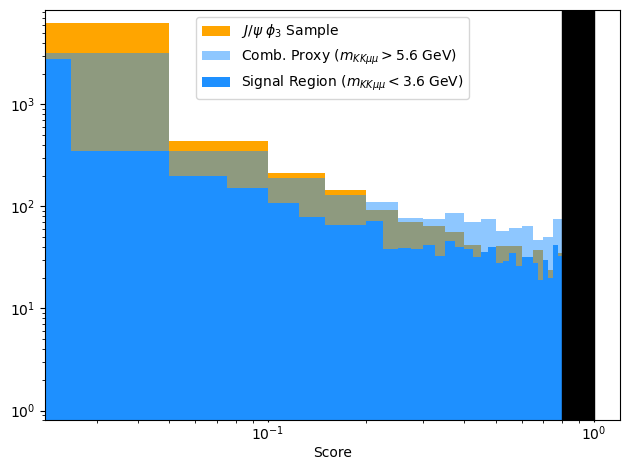

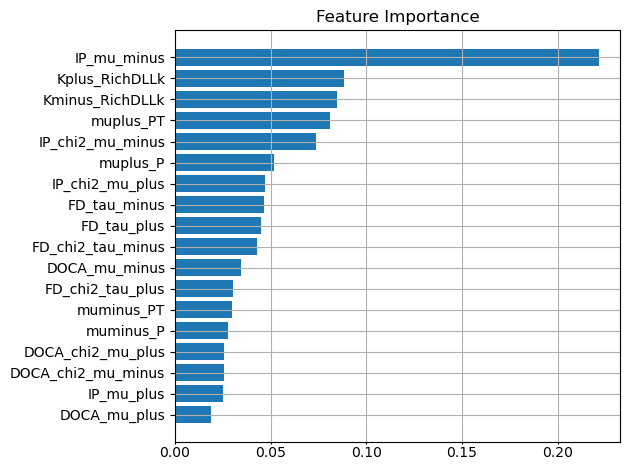

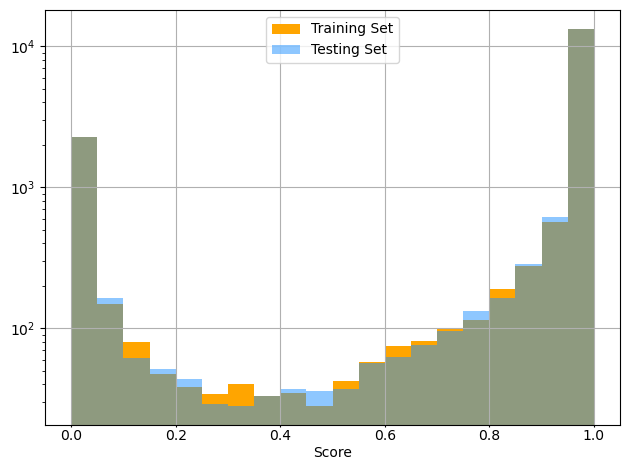

In [39]:
np.random.seed(37621)
xgb = xgboost.XGBClassifier(scale_pos_weight=scale_pos_weight)
#train_model(classifier=xgb, plot=True, save=False, is_xgb=True, info_at_threshold=threshold)
train_model(classifier=xgb, plot=True, save=True, is_xgb=True, info_at_threshold=0.744)

# Branching Fraction

## Applying ML model to data

In [40]:
def plot_mass_distributions(data_frame, bins='auto'):
    bs_kkmumu_mass_cut_mask = get_bs_kkmumu_mass_cut_mask(data_frame)
    plt.figure(figsize=[6,3])
    plot_range = (2500, 3750)
    plt.hist(data_frame._kkmumu_mass, bins=bins, range=plot_range)
    plt.axvline(_kkmumu_mass, color='k', alpha=0.5)


    plt.xlabel(r'$m_{KK\mu\mu}$')
    plt.xlim(plot_range)


In [41]:
def apply_and_plot_ml_model(classifier, threshold, data_frame, expected_FPR):
    model_x = data_frame.loc[:, BDT_COLUMNS]
    model_y_pred =  classifier.predict_proba(model_x)[:, 1]
    model_y_pred_class = model_y_pred > threshold

    after_model_data_frame = data_frame.loc[model_y_pred_class]
    plot_mass_distributions(after_model_data_frame, 100)
    plot_mass_distributions(data_frame, 100)
    plt.axvspan(*Bs_signal_region, color='C5', alpha=0.3)

    print(f"Total remaining: {len(after_model_data_frame)}")

    bs_kkmumu_mass_cut_mask = get_bs_kkmumu_mass_cut_mask(after_model_data_frame)
    after_model_after_kkmumu_mass_cut = after_model_data_frame.loc[bs_kkmumu_mass_cut_mask]
    print(f"After Bs=KKmumu mass cut: {len(after_model_after_kkmumu_mass_cut)}")

    remaining_in_signal_region = after_model_after_kkmumu_mass_cut.loc[
        (after_model_after_kkmumu_mass_cut._kkmumu_mass > Bs_signal_region[0]) 
        & (after_model_after_kkmumu_mass_cut._kkmumu_mass < Bs_signal_region[1])
    ]
    remaining_in_signal_region.to_pickle("remaining_in_signal_region.pkl.gz")

    print(f"Total remaining in signal region: {len(remaining_in_signal_region)}")

    print(f"Expected background in signal region: {B:.3f} (before ML classifier), {B * expected_FPR:.3f} (after ML classifier)")
    return len(remaining_in_signal_region),after_model_data_frame


kKmumu mass cut:
True    5
Name: _kkmumu_mass, dtype: int64
kKmumu mass cut:
True     19051
False     3067
Name: _kkmumu_mass, dtype: int64
Total remaining: 5
kKmumu mass cut:
True    5
Name: _kkmumu_mass, dtype: int64
After Bs=KKmumu mass cut: 5
Total remaining in signal region: 2
Expected background in signal region: 209.450 (before ML classifier), 0.016 (after ML classifier)


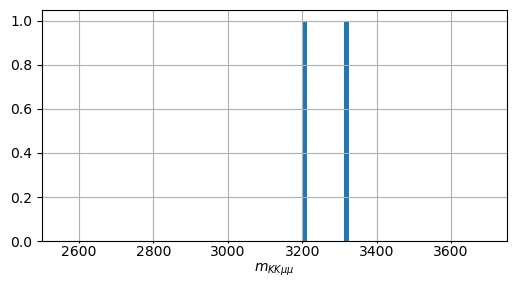

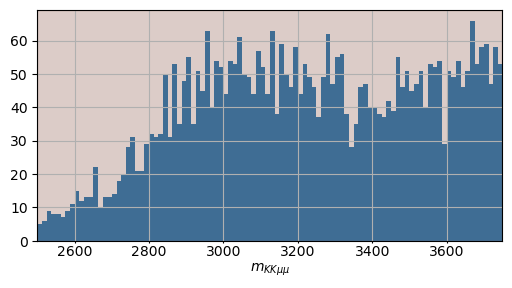

In [42]:
import xgboost

xgb = xgboost.XGBClassifier()
xgb.load_model('classifier_MC1.json')
remaining_in_signal_region,after_model_data_frame = apply_and_plot_ml_model(xgb, threshold=threshold, data_frame=Bs_df, expected_FPR=fpr)
plt.savefig('cleaned_data_after_ml_model.png', dpi=300)


Let's now compare the data before and after the ML classifier is applied for the dimuon and dikaon mass distributions

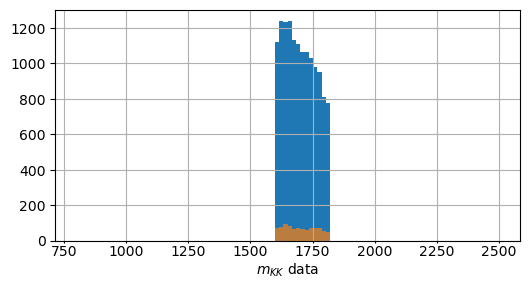

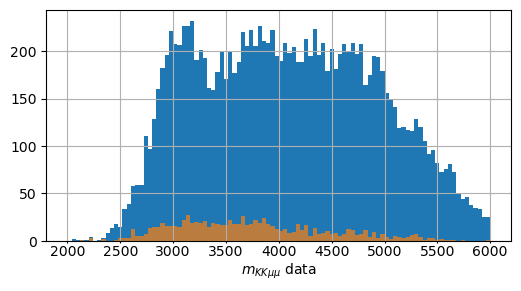

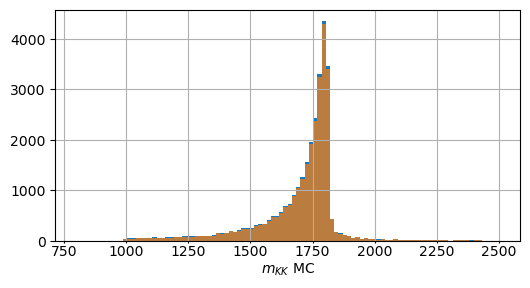

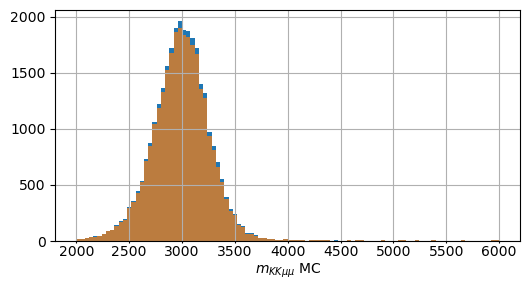

Data events pre BDT:  13757
Data events retained:  903
MC events pre BDT:  29812
MC events retained:  28863


In [45]:
threshold=0.744

signal_region_mask=(((Bs_df['phi3_M']>1600) & (Bs_df['phi3_M']<1820)) & 
                    ((Bs_df['jpsi_M'] < 3020) | (Bs_df['jpsi_M'] > 3155)) & ((Bs_df['jpsi_M'] < 3536) | (Bs_df['jpsi_M'] > 3873))
                   )

signal_region_df = Bs_df.loc[signal_region_mask]
model_x = signal_region_df.loc[:, BDT_COLUMNS]
model_y_pred =  xgb.predict_proba(model_x)[:, 1]
model_y_pred_class = model_y_pred > threshold

model_x_MC = Bs_df_signal.loc[:, BDT_COLUMNS]
model_y_pred_MC =  xgb.predict_proba(model_x_MC)[:, 1]
model_y_pred_class_MC = model_y_pred_MC > threshold

after_model_data_frame = signal_region_df.loc[model_y_pred_class]
after_model_MC=Bs_df_signal.loc[model_y_pred_class_MC]


plt.figure(figsize=[6,3])
plt.hist(signal_region_df['phi3_M'],bins=100,range=[800,2500]) 
plt.hist(after_model_data_frame['phi3_M'],bins=100,range=[800,2500], alpha=0.7)   
plt.xlabel("$m_{KK}$ data")
plt.show()

plt.figure(figsize=[6,3])
plt.hist(signal_region_df['Bs_M'],bins=100,range=[2000,6000])                    
plt.hist(after_model_data_frame['Bs_M'],bins=100,range=[2000,6000], alpha=0.7)
plt.xlabel("$m_{KK \mu \mu}$ data")
plt.show()

plt.figure(figsize=[6,3])
plt.hist(Bs_df_signal['phi3_M'],bins=100,range=[800,2500]) 
plt.hist(after_model_MC['phi3_M'],bins=100,range=[800,2500], alpha=0.7)   
plt.xlabel("$m_{KK}$ MC")
plt.show()

plt.figure(figsize=[6,3])
plt.hist(Bs_df_signal['Bs_M'],bins=100,range=[2000,6000])                    
plt.hist(after_model_MC['Bs_M'],bins=100,range=[2000,6000], alpha=0.7)
plt.xlabel("$m_{KK \mu \mu}$ MC")
plt.show()

print("Data events pre BDT: ",len(signal_region_df['_kkmumu_mass']))
print("Data events retained: ",len(after_model_data_frame['_kkmumu_mass']))

print("MC events pre BDT: ",len(Bs_df_signal['Bs_M']))
print("MC events retained: ",len(after_model_MC['Bs_M']))

## Further Analysis

Let's look at the distribution of the variables that the BDT used the most

<ipython-input-49-78e8d77de70a>:63: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(Bs_mass_range)


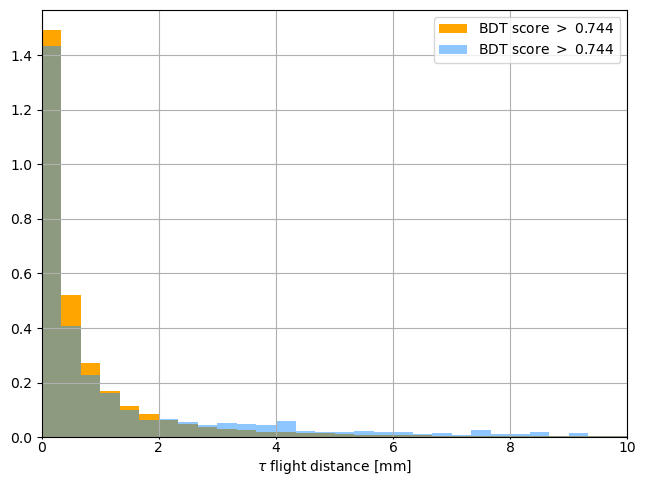

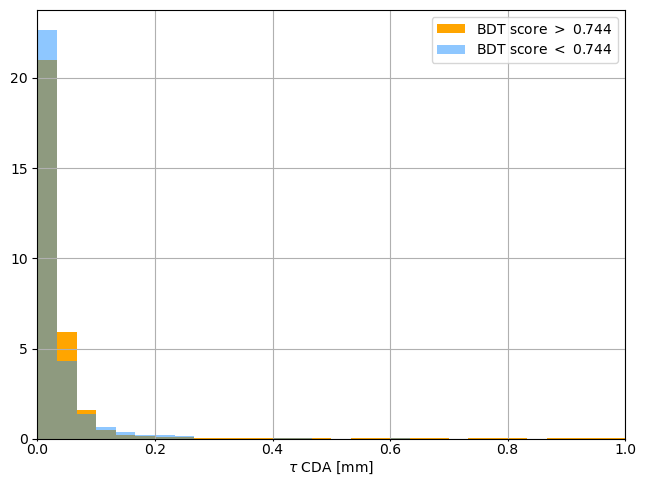

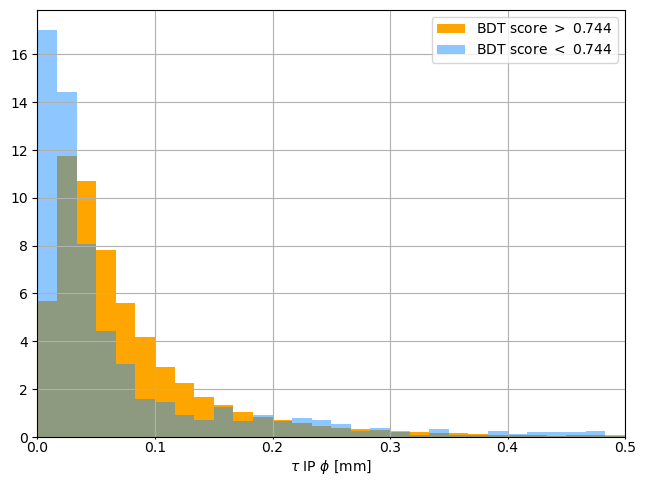

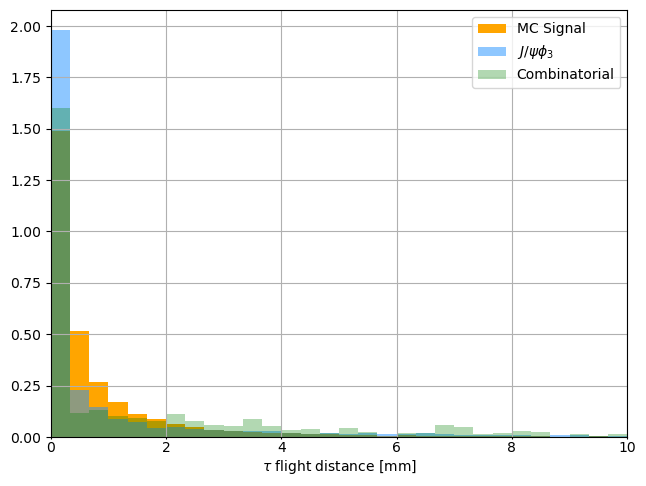

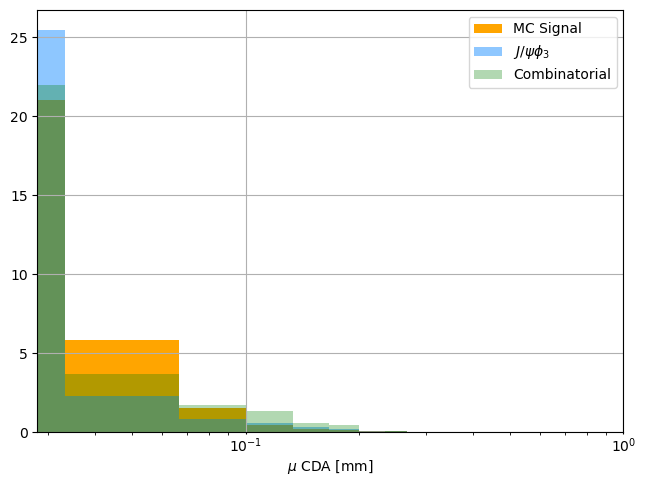

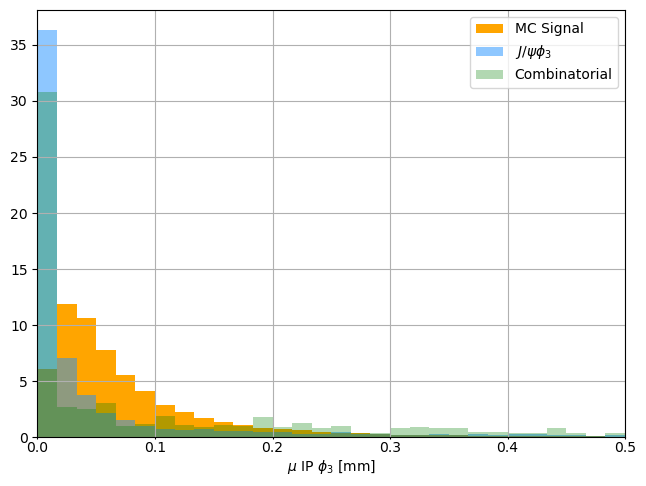

In [49]:
jpsiphi3mask=(Bs_df['jpsi_M'] > 3020) & (Bs_df['jpsi_M'] < 3155) & (Bs_df['Bs_M'] > 5200) & (Bs_df['jpsi_M'] < 5500)
combinatorial=(Bs_df['Bs_M']>5600) & ((Bs_df['jpsi_M'] < 3020) | (Bs_df['jpsi_M'] > 3155)) & ((Bs_df['jpsi_M'] < 3536) | (Bs_df['jpsi_M'] > 3873))

model_y_rej_class_MC = model_y_pred_MC < threshold

rejected_model_MC=Bs_df_signal.loc[model_y_rej_class_MC]

model_x = Bs_df.loc[:, BDT_COLUMNS]
model_y_pred =  xgb.predict_proba(model_x)[:, 1]
model_y_rej_class = model_y_pred < threshold

rejected_model_jpsi=Bs_df.loc[model_y_rej_class].loc[jpsiphi3mask]
rejected_model_comb=Bs_df.loc[model_y_rej_class].loc[combinatorial]

plt.figure()
Bs_mass_range = (0, 10)
plt.hist(after_model_MC['FD_tau_minus'], bins=30, range=Bs_mass_range,color="orange",label=r"BDT score $>$ 0.744",density=True)
plt.hist(rejected_model_MC['FD_tau_minus'], bins=30, range=Bs_mass_range,color="dodgerblue",label=r"BDT score $>$ 0.744",alpha=0.5,density=True)
plt.xlabel(r'$\tau$ flight distance [mm]')
plt.xlim(Bs_mass_range)
plt.legend()
plt.tight_layout(pad=0.5)

plt.figure()
Bs_mass_range = (0, 1)
plt.hist(after_model_MC['DOCA_mu_minus'], bins=30, range=Bs_mass_range,color="orange",label=r"BDT score $>$ 0.744",density=True)
plt.hist(rejected_model_MC['DOCA_mu_minus'], bins=30, range=Bs_mass_range,color="dodgerblue",label=r"BDT score $<$ 0.744",alpha=0.5,density=True)
plt.xlabel(r'$\tau$ CDA [mm]')
plt.xlim(Bs_mass_range)
plt.legend()
plt.tight_layout(pad=0.5)


plt.figure()
Bs_mass_range = (0, 0.5)
plt.hist(after_model_MC['IP_mu_minus'], bins=30, range=Bs_mass_range,color="orange",label=r"BDT score $>$ 0.744",density=True)
plt.hist(rejected_model_MC['IP_mu_minus'], bins=30, range=Bs_mass_range,color="dodgerblue",label=r"BDT score $<$ 0.744",alpha=0.5,density=True)
plt.xlabel(r'$\tau$ IP $\phi$ [mm]')
plt.xlim(Bs_mass_range)
plt.legend()
plt.tight_layout(pad=0.5)


#########
plt.figure()
Bs_mass_range = (0, 10)
plt.hist(Bs_df_signal['FD_tau_minus'], bins=30, range=Bs_mass_range,color="orange",label="MC Signal",density=True)
plt.hist(Bs_df.loc[jpsiphi3mask]['FD_tau_minus'], bins=30, range=Bs_mass_range,color="dodgerblue",label=r"$J/\psi \phi_3$",alpha=0.5,density=True)
plt.hist(Bs_df.loc[combinatorial]['FD_tau_minus'], bins=30, range=Bs_mass_range,color="green",label="Combinatorial",alpha=0.3,density=True)
plt.xlabel(r'$\tau$ flight distance [mm]')
plt.xlim(Bs_mass_range)
plt.legend()
plt.tight_layout(pad=0.5)


plt.figure()
Bs_mass_range = (0, 1)
plt.hist(Bs_df_signal['DOCA_mu_minus'], bins=30, range=Bs_mass_range,color="orange",label="MC Signal",density=True)
plt.hist(Bs_df.loc[jpsiphi3mask]['DOCA_mu_minus'], bins=30, range=Bs_mass_range,color="dodgerblue",label=r"$J/\psi \phi_3$",alpha=0.5,density=True)
plt.hist(Bs_df.loc[combinatorial]['DOCA_mu_minus'], bins=30, range=Bs_mass_range,color="green",label="Combinatorial",alpha=0.3,density=True)
plt.xlabel(r'$\mu$ CDA [mm]')
plt.xscale("log")
plt.xlim(Bs_mass_range)
plt.legend()
plt.tight_layout(pad=0.5)


plt.figure()
Bs_mass_range = (0, 0.5)
plt.hist(Bs_df_signal['IP_mu_minus'], bins=30, range=Bs_mass_range,color="orange",label="MC Signal",density=True)
plt.hist(Bs_df.loc[jpsiphi3mask]['IP_mu_minus'], bins=30, range=Bs_mass_range,color="dodgerblue",label=r"$J/\psi \phi_3$",alpha=0.5,density=True)
plt.hist(Bs_df.loc[combinatorial]['IP_mu_minus'], bins=30, range=Bs_mass_range,color="green",label="Combinatorial",alpha=0.3,density=True)
plt.xlabel(r'$\mu$ IP $\phi_3$ [mm]')
plt.xlim(Bs_mass_range)
plt.legend()
plt.tight_layout(pad=0.5)

Rustic visualization of correlation between CDA and IP. Might help us understand why IP is used by BDT very much, but IP distribution of signal and background is not that different

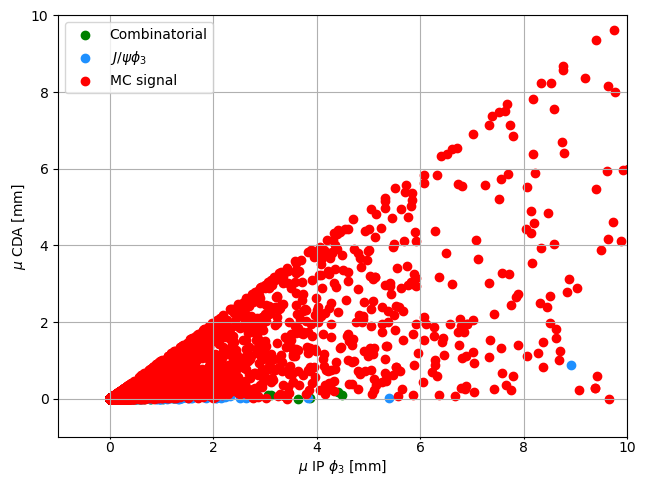

In [52]:
plt.figure()
Bs_mass_range = (0, 0.5)
plt.scatter(Bs_df.loc[combinatorial]['IP_mu_minus'],Bs_df.loc[combinatorial]['DOCA_mu_minus'],color="green",label="Combinatorial")  
plt.scatter(Bs_df.loc[jpsiphi3mask]['IP_mu_minus'],Bs_df.loc[jpsiphi3mask]['DOCA_mu_minus'],color="dodgerblue",label=r"$J/\psi \phi_3$")
plt.scatter(Bs_df_signal['IP_mu_minus'],Bs_df_signal['DOCA_mu_minus'],color="red", label="MC signal") 
plt.ylim(-1, 10)
plt.xlim(-1, 10)
plt.xlabel(r'$\mu$ IP $\phi_3$ [mm]')
plt.ylabel(r'$\mu$ CDA [mm]')
plt.legend()
plt.tight_layout(pad=0.5)
